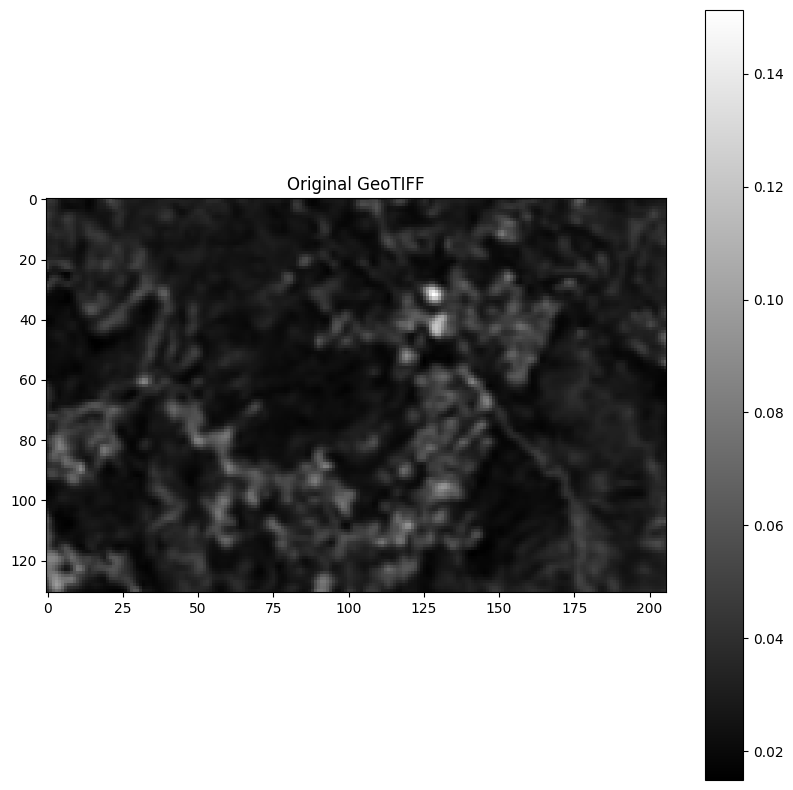

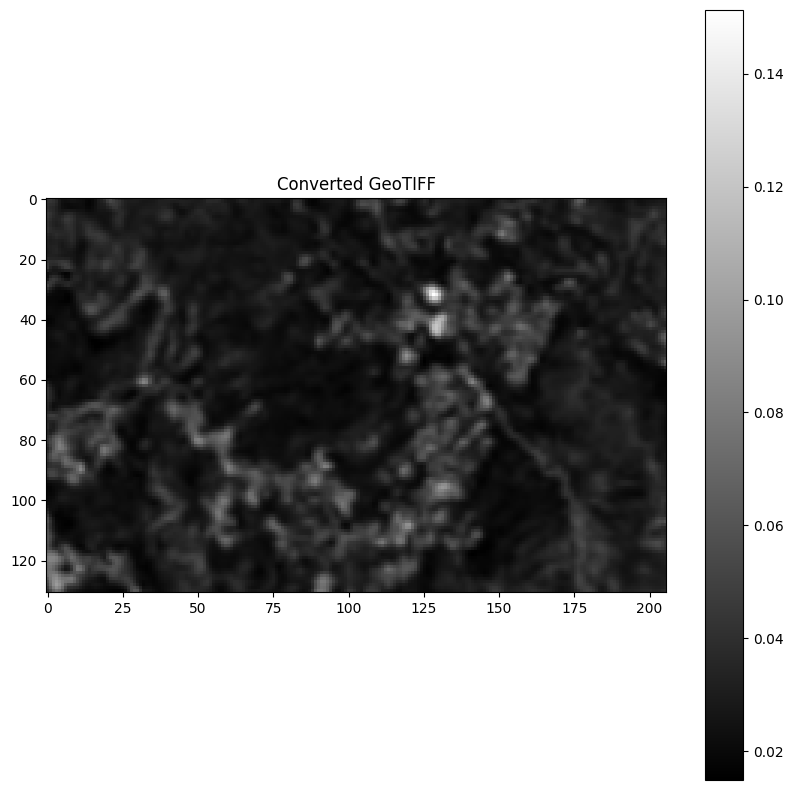

In [2]:
import rasterio
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from affine import Affine


# Paths
tiff_path = "sample-data/2024-05-07-00:00_2024-05-07-23:59_Sentinel-2_L2A_B01_(Raw).tiff"
zarr_path = "output-data/sentinel2.zarr"
new_tiff_path = "output-data/sentinel2_converted.tiff"


# Open and visualize the original GeoTIFF
with rasterio.open(tiff_path) as src:
    data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs

    # Plot the data
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='gray')
    plt.title("Original GeoTIFF")
    plt.colorbar()
    plt.show()

# Convert the GeoTIFF to an xarray.DataArray, then to a Dataset and save to Zarr
xr_data = xr.DataArray(data, dims=("y", "x"), coords={"y": np.arange(data.shape[0]), "x": np.arange(data.shape[1])})
xr_data = xr_data.to_dataset(name='band1')

# Convert transform and crs to JSON-serializable formats
xr_data.attrs['transform'] = tuple(transform)
xr_data.attrs['crs'] = crs.to_string()

xr_data.to_zarr(zarr_path, mode='w')

# Open the Zarr file and convert it back to a GeoTIFF
xr_data = xr.open_zarr(zarr_path)

# Convert transform and crs back to their original formats
transform = Affine(*xr_data.attrs['transform'])
crs = rasterio.crs.CRS.from_string(xr_data.attrs['crs'])

with rasterio.open(
    new_tiff_path, 'w',
    driver='GTiff',
    height=xr_data.band1.shape[0],
    width=xr_data.band1.shape[1],
    count=1,
    dtype=xr_data.band1.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(xr_data.band1.values, 1)

# Open and visualize the converted GeoTIFF
with rasterio.open(new_tiff_path) as src:
    new_data = src.read(1)  # Read the first band

    # Plot the data
    plt.figure(figsize=(10, 10))
    plt.imshow(new_data, cmap='gray')
    plt.title("Converted GeoTIFF")
    plt.colorbar()
    plt.show()
